<a href="https://colab.research.google.com/github/p-kris10/Universal-NST/blob/main/UniversalNST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  AutoEncoder implementation borrowed from :- https://github.com/jzenn/Image-AutoEncoder/blob/master/net.py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import os
from matplotlib import pyplot as plt

In [4]:
configuration= {   
"encoder_model_path":               '/content/drive/MyDrive/model/encoder_dict.pth', # path to the pre-trained encoder model
"decoder_model_path":               '/content/drive/MyDrive/model/'  # path to the pre-trained decoder model        
}           

#VGG Encoder

The class definition for encoder 

In [12]:
class Encoder(nn.Module):
    """
    the encoder network
    """
    def __init__(self):
        super(Encoder, self).__init__()
        # first block
        self.conv_1_1 = nn.Conv2d(3, 3, 1, 1, 0)
        self.reflecPad_1_1 = nn.ReflectionPad2d((1, 1, 1, 1))

        self.conv_1_2 = nn.Conv2d(3, 64, 3, 1, 0)
        self.relu_1_2 = nn.ReLU(inplace=True)

        self.reflecPad_1_3 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_1_3 = nn.Conv2d(64, 64, 3, 1, 0)
        self.relu_1_3 = nn.ReLU(inplace=True)

        self.maxPool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # second block
        self.reflecPad_2_1 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_2_1 = nn.Conv2d(64, 128, 3, 1, 0)
        self.relu_2_1 = nn.ReLU(inplace=True)

        self.reflecPad_2_2 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_2_2 = nn.Conv2d(128, 128, 3, 1, 0)
        self.relu_2_2 = nn.ReLU(inplace=True)

        self.maxPool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # third block
        self.reflecPad_3_1 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_3_1 = nn.Conv2d(128, 256, 3, 1, 0)
        self.relu_3_1 = nn.ReLU(inplace=True)

        self.reflecPad_3_2 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_3_2 = nn.Conv2d(256, 256, 3, 1, 0)
        self.relu_3_2 = nn.ReLU(inplace=True)

        self.reflecPad_3_3 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_3_3 = nn.Conv2d(256, 256, 3, 1, 0)
        self.relu_3_3 = nn.ReLU(inplace=True)

        self.reflecPad_3_4 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_3_4 = nn.Conv2d(256, 256, 3, 1, 0)
        self.relu_3_4 = nn.ReLU(inplace=True)

        self.maxPool_3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fourth block
        self.reflecPad_4_1 = nn.ReflectionPad2d((1, 1, 1, 1))
        self.conv_4_1 = nn.Conv2d(256, 512, 3, 1, 0)
        self.relu_4_1 = nn.ReLU(inplace=True)

    def forward(self, input):
        output = {}

        # first block
        out = self.conv_1_1(input)
        out = self.reflecPad_1_1(out)
        out = self.conv_1_2(out)
        out = self.relu_1_2(out)

        output['r11'] = out

        out = self.reflecPad_1_3(out)
        out = self.conv_1_3(out)
        out = self.relu_1_3(out)

        out = self.maxPool_1(out)

        # second block
        out = self.reflecPad_2_1(out)
        out = self.conv_2_1(out)
        out = self.relu_2_1(out)

        output['r21'] = out

        out = self.reflecPad_2_2(out)
        out = self.conv_2_2(out)
        out = self.relu_2_2(out)

        out = self.maxPool_2(out)

        # third block
        out = self.reflecPad_3_1(out)
        out = self.conv_3_1(out)
        out = self.relu_3_1(out)

        output['r31'] = out

        out = self.reflecPad_3_2(out)
        out = self.conv_3_2(out)
        out = self.relu_3_2(out)

        out = self.reflecPad_3_3(out)
        out = self.conv_3_3(out)
        out = self.relu_3_3(out)

        out = self.reflecPad_3_4(out)
        out = self.conv_3_4(out)
        out = self.relu_3_4(out)

        out = self.maxPool_3(out)

        # fourth block
        out = self.reflecPad_4_1(out)
        out = self.conv_4_1(out)
        out = self.relu_4_1(out)

        output['r41'] = out

        return output


# Decoders

In [14]:
class Decoder(nn.Module):
  def __init__(self,weights):
        super(Decoder, self).__init__()

        
        self.decode_relu1_1 = nn.Sequential( 
            nn.ReflectionPad2d((1, 1, 1, 1)),
	          nn.Conv2d(64,3,(3, 3)),
          )
        self.decode_relu1_1.load_state_dict(torch.load(os.path.join(weights,"feature_invertor_conv1_1.pth")))
        
        self.decode_relu2_1 = nn.Sequential( 
             nn.ReflectionPad2d((1, 1, 1, 1)),
              nn.Conv2d(128,64,(3, 3)),
              nn.ReLU(),
              nn.UpsamplingNearest2d(scale_factor=2),
              nn.ReflectionPad2d((1, 1, 1, 1)),
              nn.Conv2d(64,64,(3, 3)),
              nn.ReLU(),
              nn.ReflectionPad2d((1, 1, 1, 1)),
              nn.Conv2d(64,3,(3, 3)),
            )
        
        self.decode_relu2_1.load_state_dict(torch.load(os.path.join(weights,"feature_invertor_conv2_1.pth")))

        self.decode_relu3_1 = nn.Sequential( 
                    nn.ReflectionPad2d((1, 1, 1, 1)),
                    nn.Conv2d(256,128,(3, 3)),
                    nn.ReLU(),
                    nn.UpsamplingNearest2d(scale_factor=2),
                    nn.ReflectionPad2d((1, 1, 1, 1)),
                    nn.Conv2d(128,128,(3, 3)),
                    nn.ReLU(),
                    nn.ReflectionPad2d((1, 1, 1, 1)),
                    nn.Conv2d(128,64,(3, 3)),
                    nn.ReLU(),
                    nn.UpsamplingNearest2d(scale_factor=2),
                    nn.ReflectionPad2d((1, 1, 1, 1)),
                    nn.Conv2d(64,64,(3, 3)),
                    nn.ReLU(),
                    nn.ReflectionPad2d((1, 1, 1, 1)),
                    nn.Conv2d(64,3,(3, 3)),
                  )
        self.decode_relu3_1.load_state_dict(torch.load(os.path.join(weights,"feature_invertor_conv3_1.pth")))
        
        self.decode_relu4_1 = nn.Sequential( 
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,256,(3, 3)),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,128,(3, 3)),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,128,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,64,(3, 3)),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,64,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,3,(3, 3)),
          )
        
        self.decode_relu4_1.load_state_dict(torch.load(os.path.join(weights,"feature_invertor_conv4_1.pth")))
        

  def forward(self,input,level):
    assert (type(level).__name__ == 'int' and 1 <= level <= 4)
    if(level == 4):
      return self.decode_relu4_1(input)
    elif(level == 3):
      return self.decode_relu3_1(input)
    elif(level == 2):
      return self.decode_relu2_1(input)
    elif(level == 1):
      return self.decode_relu1_1(input)






#Paper Snippet

 Some formulas from the paper required for image transformation  ->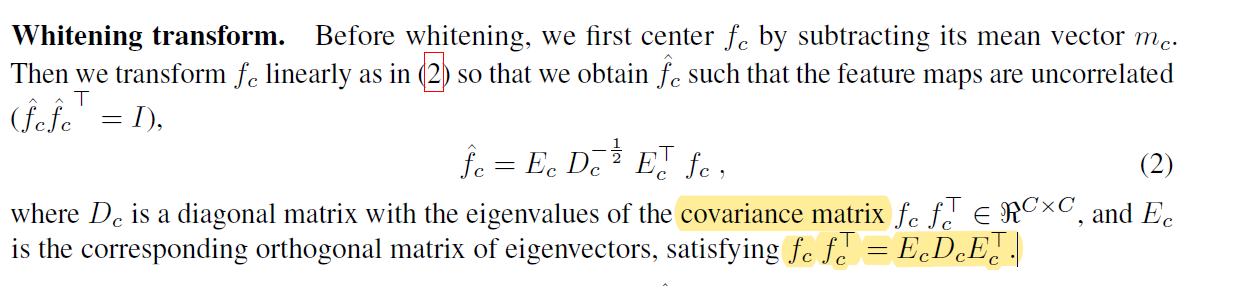

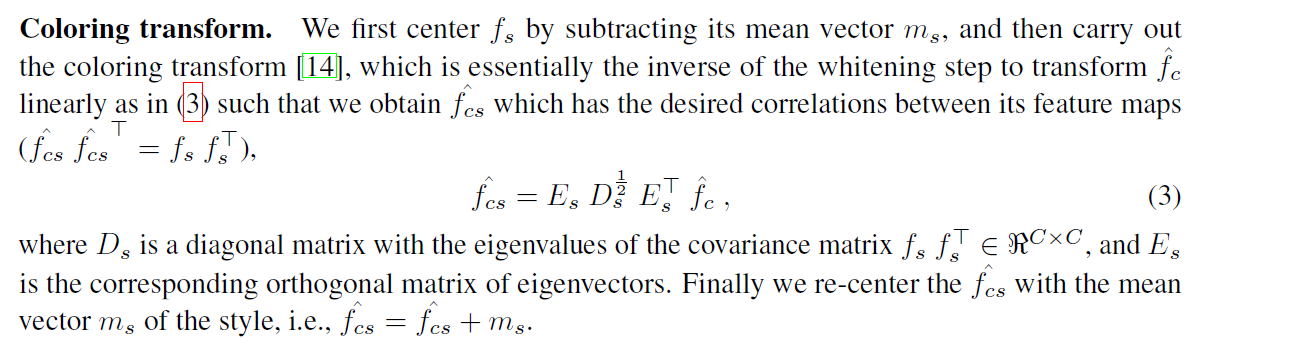
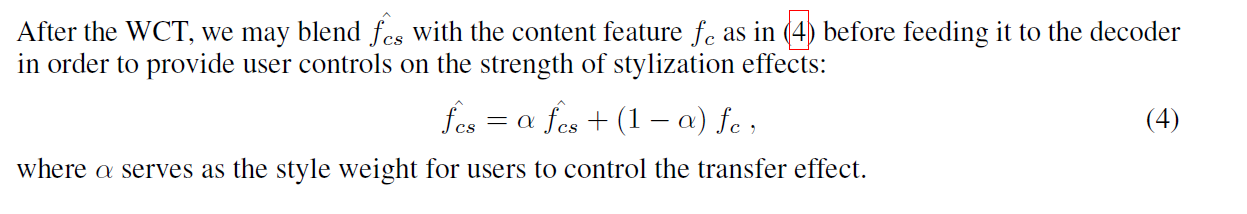

#Autoencoder
Combining the Encoder And Decoder to create the Autoencoder Class

In [15]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Autoencoder(nn.Module):
    """
    the autoencoder class
    """
    def __init__(self,lambda_1, lambda_2, lambda_tv):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = Encoder()
        self.encoder.load_state_dict(torch.load(configuration['encoder_model_path'], map_location='cpu'))

        # decoder
        self.decoder = Decoder(configuration["decoder_model_path"])

        # loss
        self.l2_loss = L2Loss()
        
        #encoder output options
        self.options = ['r11','r21','r31','r41']

        # loss balancing
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_tv = lambda_tv


    def forward(self, input, style_input,level,alpha):
        # encode input
        chosen_layer = self.options[level-1];
        #plt.imshow(input.detach().clone().squeeze(0).permute(1,2,0))
        input_encoded = self.encoder(input)[chosen_layer]
        style_encoded = self.encoder(style_input)[chosen_layer]
        #apply transforms here
        
        colored_feature = self.whiten_and_color(input_encoded,style_encoded)
        blended_feature = alpha*colored_feature + (1-alpha)*input_encoded
        # # get output
        # print("sjhape",colored_feature.shape)
        output = self.decoder(blended_feature,level)

       

        #plt.imshow(output.detach().squeeze(0).permute(1,2,0))
        # encode output
        output_encoded = self.encoder(output)[chosen_layer]

        # MSELoss(self, input, target) => input_features are the target
        loss, feature_loss, per_pixel_loss = self.calculate_loss(output, input, output_encoded, input_encoded)
        output = self.clamp(output.detach().clone().squeeze(0).permute(1,2,0).numpy())
        return output, loss, feature_loss, per_pixel_loss

    def calculate_loss(self, input, target, input_features, target_features):
        """
        calculates the network loss (feature loss and per-pixel loss and TV loss)
        @param input: output image of the network
        @param target: original input image of the network
        @param input_features: encoding of image @param input
        @param target_features: encoding of image @param target
        @return:
        """
        # feature loss on relu_4
        content_feature_loss = self.l2_loss(input_features.to(device), target_features.to(device))

        # per pixel loss on the images
        per_pixel_loss = self.l2_loss(input, target).to(device)

        # tv regularizer
        tv_regularizer = self.tv_regularizer(input)

        # loss is sum of losses
        loss = self.lambda_tv * tv_regularizer + \
               self.lambda_1 * content_feature_loss + \
               self.lambda_2 * per_pixel_loss

        return loss.to(device), content_feature_loss, per_pixel_loss

    def clamp(self,img_data_np):
      min_val = np.min(img_data_np)
      max_val = np.max(img_data_np)
      img_data_clamped = (img_data_np - min_val) / (max_val - min_val)
      return img_data_clamped

    #whiteen_andcolor function
    def whiten_and_color(self,content_feature, style_feature, alpha=1):
      """
      A WCT function can be used directly between encoder and decoder
      """
      cf = content_feature.squeeze(0)
      c, ch, cw = cf.shape
      cf = cf.reshape(c, -1)
      c_mean = torch.mean(cf, 1, keepdim=True)
      #centering the data
      cf = cf - c_mean
      c_cov = torch.mm(cf, cf.t()).div(ch*cw - 1)
      c_u, c_e, c_v = torch.svd(c_cov)

      # if necessary, use k-th largest eig-value
      k_c = c
      for i in range(c):
          if c_e[i] < 0.00001:
              k_c = i
              break
      c_d = c_e[:k_c].pow(-0.5)

      w_step1 = torch.mm(c_v[:, :k_c], torch.diag(c_d))
      w_step2 = torch.mm(w_step1, (c_v[:, :k_c].t()))
      whitened = torch.mm(w_step2, cf)

      sf = style_feature.squeeze(0)
      c, sh, sw = sf.shape
      sf = sf.reshape(c, -1)
      s_mean = torch.mean(sf, 1, keepdim=True)
      sf = sf - s_mean
      s_cov = torch.mm(sf, sf.t()).div(sh*sw -1)
      s_u, s_e, s_v = torch.svd(s_cov)

      # if necessary, use k-th largest eig-value
      k_s = c
      for i in range(c):
          if s_e[i] < 0.00001:
              k_s = i
              break
      s_d = s_e[:k_s].pow(0.5)
      c_step1 = torch.mm(s_v[:, :k_s], torch.diag(s_d))
      c_step2 = torch.mm(c_step1, s_v[:, :k_s].t())
      colored = torch.mm(c_step2, whitened) + s_mean

      colored_feature = colored.reshape(c, ch, cw).unsqueeze(0).float()

      colored_feature = alpha * colored_feature + (1.0 - alpha) * content_feature
      return colored_feature

    


    def tv_regularizer(self, input, beta=2.):
        """
        a total variational regularizer (reduces high frequency structures)
        @param input:
        @param beta:
        @return:
        """
        dy = torch.zeros(input.size())
        dx = torch.zeros(input.size())
        dy[:, 1:, :] = -input[:, :-1, :] + input[:, 1:, :]
        dx[:, :, 1:] = -input[:, :, :-1] + input[:, :, 1:]
        return torch.sum((dx.pow(2) + dy.pow(2)).pow(beta / 2.))


########################################################################
# loss
########################################################################

class L2Loss(nn.Module):
    """
    simple L_2-Loss
    """
    def __init__(self):
        super(L2Loss, self).__init__()

    def forward(self, input, target):
        return torch.sqrt(torch.mean(torch.abs(input - target).pow(2)))


In [16]:
transform = transforms.Compose([transforms.Resize((400,400)),   
                                       transforms.ToTensor(), 
                                       ]) 
def image_loader(image_name, add_fake_batch_dimension=True):
    """
    loads an image
    :param image_name: the path of the image
    :param transformation: the transformation done on the image
    :param add_fake_batch_dimension: should add a 4th batch dimension
    :return: the image on the current device
    """
    image = Image.open(image_name).convert('RGB')
    #rint(image.size)
    image = transform(image)

    # fake batch dimension required to fit network's input dimensions
    if add_fake_batch_dimension:
        image = image.unsqueeze(0)
    return image

In [17]:
content_image = image_loader('/content/drive/MyDrive/nst_images/golden_gate.jpg',)
style_image = image_loader('/content/drive/MyDrive/nst_images/psychedelic.jpg')


### Visualise the content and style image

Content Image

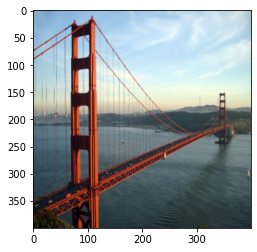

In [18]:
plt.imshow(content_image.squeeze(0).permute(1,2,0))

Style Image

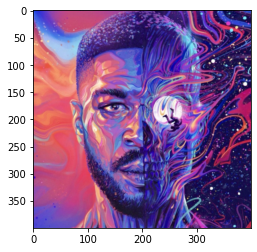

In [19]:
plt.imshow(style_image.squeeze(0).permute(1,2,0))

In [20]:
encoder_decoder_model = Autoencoder(0,0,0)
encoder_decoder_model.eval()

Autoencoder(
  (encoder): Encoder(
    (conv_1_1): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (reflecPad_1_1): ReflectionPad2d((1, 1, 1, 1))
    (conv_1_2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu_1_2): ReLU(inplace=True)
    (reflecPad_1_3): ReflectionPad2d((1, 1, 1, 1))
    (conv_1_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu_1_3): ReLU(inplace=True)
    (maxPool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (reflecPad_2_1): ReflectionPad2d((1, 1, 1, 1))
    (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu_2_1): ReLU(inplace=True)
    (reflecPad_2_2): ReflectionPad2d((1, 1, 1, 1))
    (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (relu_2_2): ReLU(inplace=True)
    (maxPool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (reflecPad_3_1): ReflectionPad2d((1, 1, 1, 1))
    (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), str

#Single Level Stylization

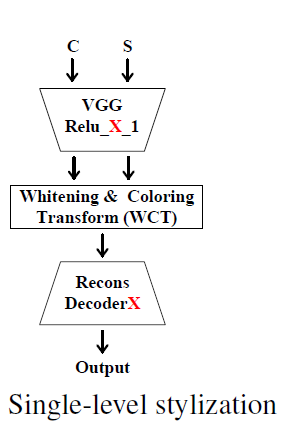

In [ ]:
result_image = encoder_decoder_model(content_image,style_image,4,0.8)[0] # encoder_decoder_model(content_image,style_image,relu_layer,alpha)

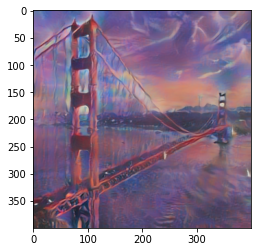

In [ ]:
plt.imshow(result_image)

## Multilevel Stylization

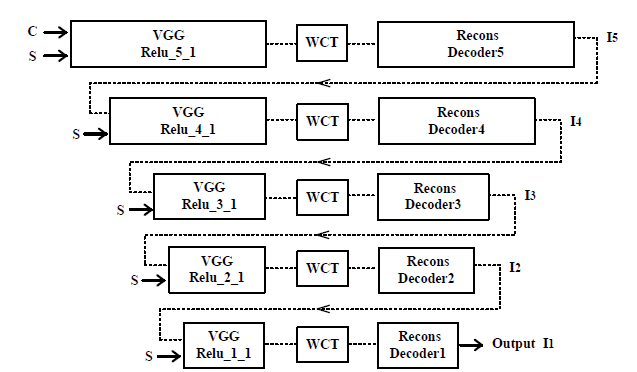

In [ ]:
#multilevel stylization
result_image = encoder_decoder_model(content_image,style_image,4,0.8)[0]
result_image = transform(Image.fromarray((result_image*255).astype(np.uint8)))
result_image = encoder_decoder_model(result_image,style_image,3,0.8)[0]
result_image = transform(Image.fromarray((result_image*255).astype(np.uint8)))
result_image = encoder_decoder_model(result_image,style_image,2,0.8)[0]
result_image = transform(Image.fromarray((result_image*255).astype(np.uint8)))
result_image = encoder_decoder_model(result_image,style_image,1,0.8)[0]

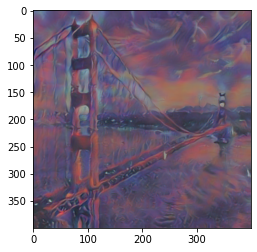

In [ ]:
plt.imshow(result_image)

# Webcam capture NST

In [30]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  im_pil =  PIL.Image.fromarray(img)

  return im_pil

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_array = bbox_array * 255
  bbox_array = bbox_array.astype(np.uint8)
  bbox_PIL = PIL.Image.fromarray(bbox_array)
  print("This ran")
  display(bbox_PIL)
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  #img = img.resize((224,224))
  img = transform(img)
  
  # call our darknet helper on webcam image
  nst = encoder_decoder_model(img,style_image,4,0.8)[0]
  print(nst.shape)
  x = bbox_to_bytes(nst)
  # save image
  #plt.imshow(input.detach().clone().squeeze(0).permute(1,2,0))
  plt.imsave(filename,nst)

  return filename

<IPython.core.display.Javascript object>

(400, 400, 3)
This ran


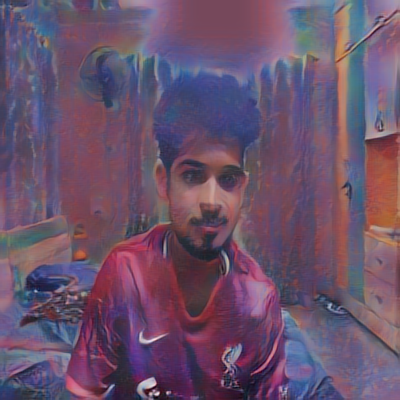

Saved to photo.jpg
display fn


In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  print("display fn")
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## NST on Web cam capture Video

In [21]:
from google.colab.patches import cv2_imshow
from skimage.transform import resize

In [22]:
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode
 
def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
       
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";
 
      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);
 
      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';
 
      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
     
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
 
      video.srcObject = stream;
      video.muted = true;
 
      await video.play();
 
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
 
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
       
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();
 
      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [23]:
record_video("nst.mp4")

<IPython.core.display.Javascript object>

Finished recording video at:nst.mp4


In [26]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    

  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")


In [27]:
show_video("nst.mp4")

In [28]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), ]) 

In [31]:
 # Video Capture (video_file)
video_capture = cv2.VideoCapture("/content/nst.mp4")
start_time = time.time()

frame_width = int(video_capture.get(3))
frame_height = int(video_capture.get(4))
#fps = int(video_capture.get(5))
size = (224, 224)

#Initialize video writer
result = cv2.VideoWriter('result.avi', cv2.VideoWriter_fourcc(*'MJPG'),20.0, size)

while True:
  ret, frame = video_capture.read()
  if not ret:
      print('Unable to read video / Video ended')
      break

  frame = cv2.flip(frame, 1)
  image_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  img =  PIL.Image.fromarray(image_np)

  img = transform(img)


  # Pass frame through detector
  nst = encoder_decoder_model(img,style_image,4,0.8)[0]



  # Display detections
  #visualise_on_image(frame, bboxes, labels, scores, score_thresh)

  end_time = time.time()
  fps = int(1/(end_time - start_time))
  start_time = end_time
  #cv2.putText(nst, f"FPS: {fps}", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)
  #cv2_imshow(frame)
  nst = (nst*255).astype(np.uint8)
  #Write output video
  result.write(nst)

video_capture.release()

Unable to read video / Video ended


In [32]:
!ffmpeg -i result.avi result.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [33]:
show_video("result.mp4")